In [1]:
from itertools import product
import numpy as np
import pandas as pd
from ADRprofilePrediction import Pairs2Mat, evaluation
from Models import loadHyperpar
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as path_effects
import json

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


In [3]:
features_dict = {
    "target":Pairs2Mat(path="data/drug_target.tsv",colname1="0",colname2="1"),
    "enzyme":Pairs2Mat(path="data/drug_enzyme.tsv",colname1="0",colname2="1"),
    "Chem":pd.read_csv("data/drug_chemsfp.tsv",sep = "\t",header=0,index_col=0),
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name"),
    "transporter":Pairs2Mat(path="data/drug_transporter.tsv",colname1="0",colname2="1"),
    "pathway":Pairs2Mat(path="data/drug_pathway.tsv",colname1="0",colname2="1"),
    "indication":Pairs2Mat(path="data/drug_indication.tsv",colname1="1_x",colname2="6")
}


In [4]:
filter = "rare"
SEs = {}
if filter == "all":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums >= 0)]

    OFFSIDERS = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDERS, axis=0)
    SEs["OFFSIDES"] = OFFSIDERS.loc[:, column_sums >= 0]
elif filter == "rare":
    SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
    column_sums = np.sum(SIDER, axis=0)
    SEs["SIDER"] = SIDER.loc[:, (column_sums < 50)]

    OFFSIDERS = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
    column_sums = np.sum(OFFSIDERS, axis=0)
    SEs["OFFSIDES"] = OFFSIDERS.loc[:, column_sums < 50]


In [5]:
SEs["SIDER"].shape

(1344, 5481)

In [6]:
SEs["OFFSIDES"].shape

(2730, 6172)

In [7]:
features_names = ["target", "enzyme", "Chem", "DGI", "transporter", "pathway", "indication"]
# SEs_names = ["SIDER", "OFFSIDES"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR"]
methods = ["SKR", "KRR", "VKR", "Naive", "LNSM_RLN", "LNSM_jaccard"]
# methods = ["SKR", "KR", "KRR", "Naive", "LNSM_RLN", "LNSM_jaccard", "VKR", "SVM", "OCCA", "SCCA", "RF", "BRF"]
tuning_metrices=["AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]
metrice_names = ["AUPR+AUROC", "AUPR+AUROCperdrug", "AUROC", "AUPR", "AUROCperdrug", "AUPRperdrug"]

In [8]:
A = 10**np.arange(-2, 3, 1, dtype=float)
B = np.arange(0.1, 1, 0.1, dtype=float)
C = np.arange(5, 20, 5, dtype=int)
A10 = 10**np.arange(1, 2, 1, dtype=float)
A100 = 10**np.arange(2, 3, 1, dtype=float)
all_hyperparlist = {
    "SKR":[A,B,A10,A100], 
    # "KR":[A,A], 
    "KRR":[A,A],
    "VKR":[A,A,C], 
    "Naive":[], 
    "LNSM_RLN":[B,A], 
    "LNSM_jaccard":[B], 
    # "SVM":[A,A,A], 
    # "OCCA":[], 
    # "SCCA":[A], 
    # "RF":[C], 
    # "BRF":[C]
}

In [9]:
SEs_name = "SIDER"
metrice = "AUPR"

In [10]:
hyperpars = {}
hyperpars["nested_cv"] = {}
hyperpars["cv"] = {}
hyperparsOut = {}
hyperparsOut["nested_cv"] = {}
hyperparsOut["cv"] = {}
results = {}
results["nested_cv"] = {}
results["cv"] = {}

In [11]:
# hyperpars["nested_cv"]["SKR"] = {}
# hyperpars["nested_cv"]["SKR"]["target"] = [
#     (0.01, 0.4, 10, 100),
#     (0.01, 0.4, 10, 100),
#     (0.01, 0.4, 10, 100),
#     (0.01, 0.5, 10, 100),
#     (0.01, 0.4, 10, 100),
#     ]
# hyperpars["nested_cv"]["SKR"]["enzyme"] = [
#     (0.01, 0.6, 10, 100),
#     (1, 0.8, 10, 100),
#     (1, 0.2, 10, 100),
#     (1, 0.2, 10, 100),
#     (1, 0.2, 10, 100),
#     ]
# hyperpars["nested_cv"]["SKR"]["Chem"] = [
#     (1, 0.3, 10, 100),
#     (1, 0.3, 10, 100),
#     (1, 0.3, 10, 100),
#     (1, 0.3, 10, 100),
#     (1, 0.3, 10, 100),
#     ]
# hyperpars["nested_cv"]["SKR"]["DGI"] = [
#     (0.1, 0.2, 10, 100),
#     (0.1, 0.2, 10, 100),
#     (0.1, 0.2, 10, 100),
#     (0.1, 0.1, 10, 100),
#     (0.1, 0.2, 10, 100),
#     ]
# # hyperpars["nested_cv"]["SKR"]["transporter"] = [
# #     (1, 0.3, 10, 1),
# #     (1, 0.1, 10, 100),
# #     (0.1, 0.5, 10, 100),
# #     (0.1, 0.5, 10, 100),
# #     (0.1, 0.5, 10, 100),
# #     ]
# hyperpars["nested_cv"]["SKR"]["transporter"] = [
#     (1, 0.1, 10, 100),
#     (1, 0.1, 10, 100),
#     (0.1, 0.5, 10, 100),
#     (0.1, 0.5, 10, 100),
#     (0.1, 0.5, 10, 100),
#     ]
# hyperpars["nested_cv"]["SKR"]["pathway"] = [
#     (0.01, 0.3, 10, 100),
#     (0.01, 0.3, 10, 100),
#     (0.01, 0.3, 10, 100),
#     (0.01, 0.3, 10, 100),
#     (0.01, 0.3, 10, 100),
#     ]
# hyperpars["nested_cv"]["SKR"]["indication"] = [
#     (0.1, 0.1, 10, 100),
#     (0.1, 0.1, 10, 100),
#     (0.1, 0.1, 10, 100),
#     (0.1, 0.1, 10, 100),
#     (0.1, 0.1, 10, 100),
#     ]
# # hyperpars["cv"]["SKR"] = {}
# # hyperpars["cv"]["SKR"]["target"] = (10, 0.9, 10, 100)
# # hyperpars["cv"]["SKR"]["enzyme"] = (1, 0.9, 10, 100)
# # hyperpars["cv"]["SKR"]["Chem"] = (0.01, 0.7, 100, 100)
# # hyperpars["cv"]["SKR"]["DGI"] =(0.1, 0.4, 100, 100)
# # hyperpars["cv"]["SKR"]["transporter"] = (10, 0.9, 10, 10)
# # hyperpars["cv"]["SKR"]["pathway"] = (0.1, 0.4, 100, 10)
# # hyperpars["cv"]["SKR"]["indication"] = (1, 0.4, 100, 10)
# hyperpars["cv"]["SKR"] = {}
# hyperpars["cv"]["SKR"]["target"] = (10, 0.9, 10, 100)
# hyperpars["cv"]["SKR"]["enzyme"] = (1, 0.9, 10, 100)
# hyperpars["cv"]["SKR"]["Chem"] = (1, 0.9, 10, 100)
# hyperpars["cv"]["SKR"]["DGI"] =(1, 0.9, 10, 100)
# hyperpars["cv"]["SKR"]["transporter"] = (100, 0.9, 10, 100)
# hyperpars["cv"]["SKR"]["pathway"] = (100, 0.5, 10, 100)
# hyperpars["cv"]["SKR"]["indication"] = (1, 0.9, 10, 100)

In [12]:
# hyperpars["nested_cv"]["KRR"] = {}
# hyperpars["nested_cv"]["KRR"]["target"] = [
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["enzyme"] = [
#     (1, 10),
#     (10, 10),
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["Chem"] = [
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["DGI"] = [
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["transporter"] = [
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     (1, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["pathway"] = [
#     (0.01, 10),
#     (0.01, 10),
#     (0.01, 10),
#     (0.01, 10),
#     (0.01, 10),
#     ]
# hyperpars["nested_cv"]["KRR"]["indication"] = [
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     (0.1, 10),
#     ]
# hyperpars["cv"]["KRR"] = {}
# hyperpars["cv"]["KRR"]["target"] = (100, 10)
# hyperpars["cv"]["KRR"]["enzyme"] = (100, 10)
# hyperpars["cv"]["KRR"]["Chem"] = (0.1, 100)
# hyperpars["cv"]["KRR"]["DGI"] = (0.1, 100)
# hyperpars["cv"]["KRR"]["transporter"] = (100, 100)
# hyperpars["cv"]["KRR"]["pathway"] = (0.1, 100)
# hyperpars["cv"]["KRR"]["indication"] = (100, 100)

In [13]:

# # Open and read the JSON file
# with open(f'results/hyperpars_{SEs_name}.xml', 'r') as xml_file:
#     hyperpars = json.load(xml_file)

In [14]:
results={}
for c in np.arange(0, 1, 0.1):
    method = "SKR"
    validation = "nested_cv"
    hyperpars = [
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    (0.01, c, 10, 100),
    ]
    str = "DGI"
    print(f"using feature {str}")
    hyperparList = loadHyperpar(*all_hyperparlist[method],method_option=method)
    results[c], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparList=hyperparList,hyperparfixed=hyperpars,Validation=validation,n_jobs=1)
    

using feature DGI
The SKR requires hyperparameter lambda, c, sigma_X, sigma_Y
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  45
first few training idx:  [ 78 305 355 378 498 546 622 647 680 723]
first few testing idx:  [139 282 369 438 510 565 659 676 684 726]
--- tuning end ---
target size: 146
------ best hyper pars:  (0.01, 0.0, 10, 100) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.0980159498998838
AUROCperdrug: 0.6857177362102246
AUPR+AUROCperdrug: 0.7837336861101084
AUPR: 0.0572340587597667
AUROC: 0.6555702806727252
AUPR+AUROC: 0.7128043394324919
-----------
Fold: 1
number of hyperpars combination:  45
first few training idx:  [139 282 369 438 510 565 659 676 684 726]
first few testing idx:  [ 78 305 355 378 498 546 622 647 680 723]
--- tuning end ---
target size: 146
------ best hyper pars:  (0.01, 0.0, 10, 100) ------
SKR starts:
SKR ends:
-----------
AUPRperdrug: 0.0920543745498983
AUROCperdrug: 0.672560575996625
AUPR+AUROCperdrug: 0.

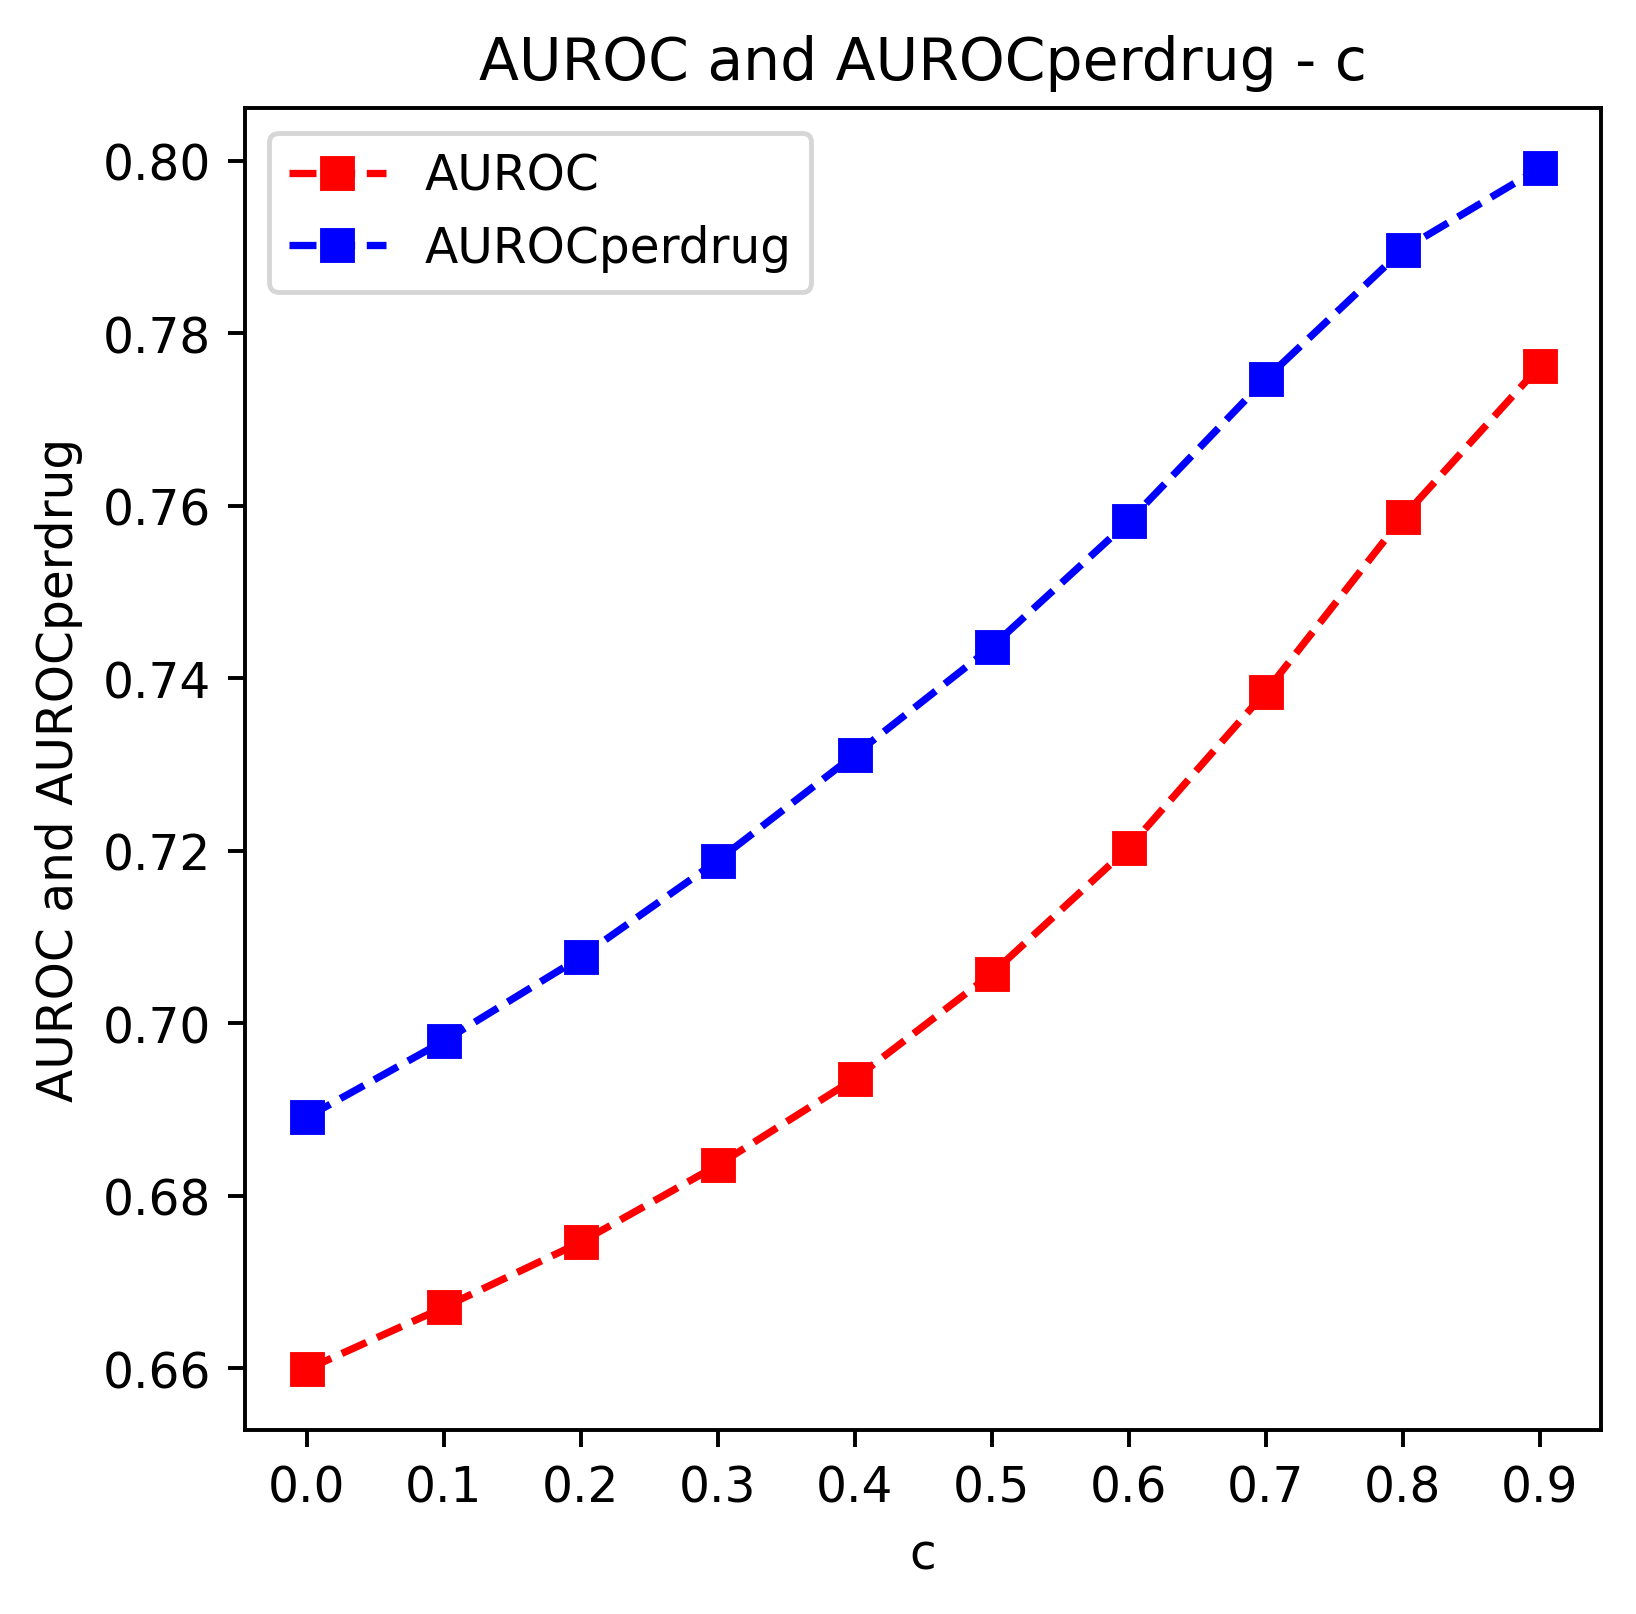

In [15]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUROC"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUROC')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUROCperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUROCperdrug')

# df = pd.DataFrame()
# for c, metrics in results.items():

#     df1 = pd.DataFrame(metrics["AUPR+AUROCperdrug"]).mean()
#     df = pd.concat([df, df1], ignore_index=True)

# plt.plot(df, marker='s', linestyle='--', color='black', label='Naive')

xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1))
# Add a legend
plt.legend()
plt.title("AUROC and AUROCperdrug - c")
# Show the plot
plt.xlabel('c')
plt.ylabel('AUROC and AUROCperdrug')
plt.savefig(fname=f"figs/AUROC-C.jpg", bbox_inches="tight")
plt.show()

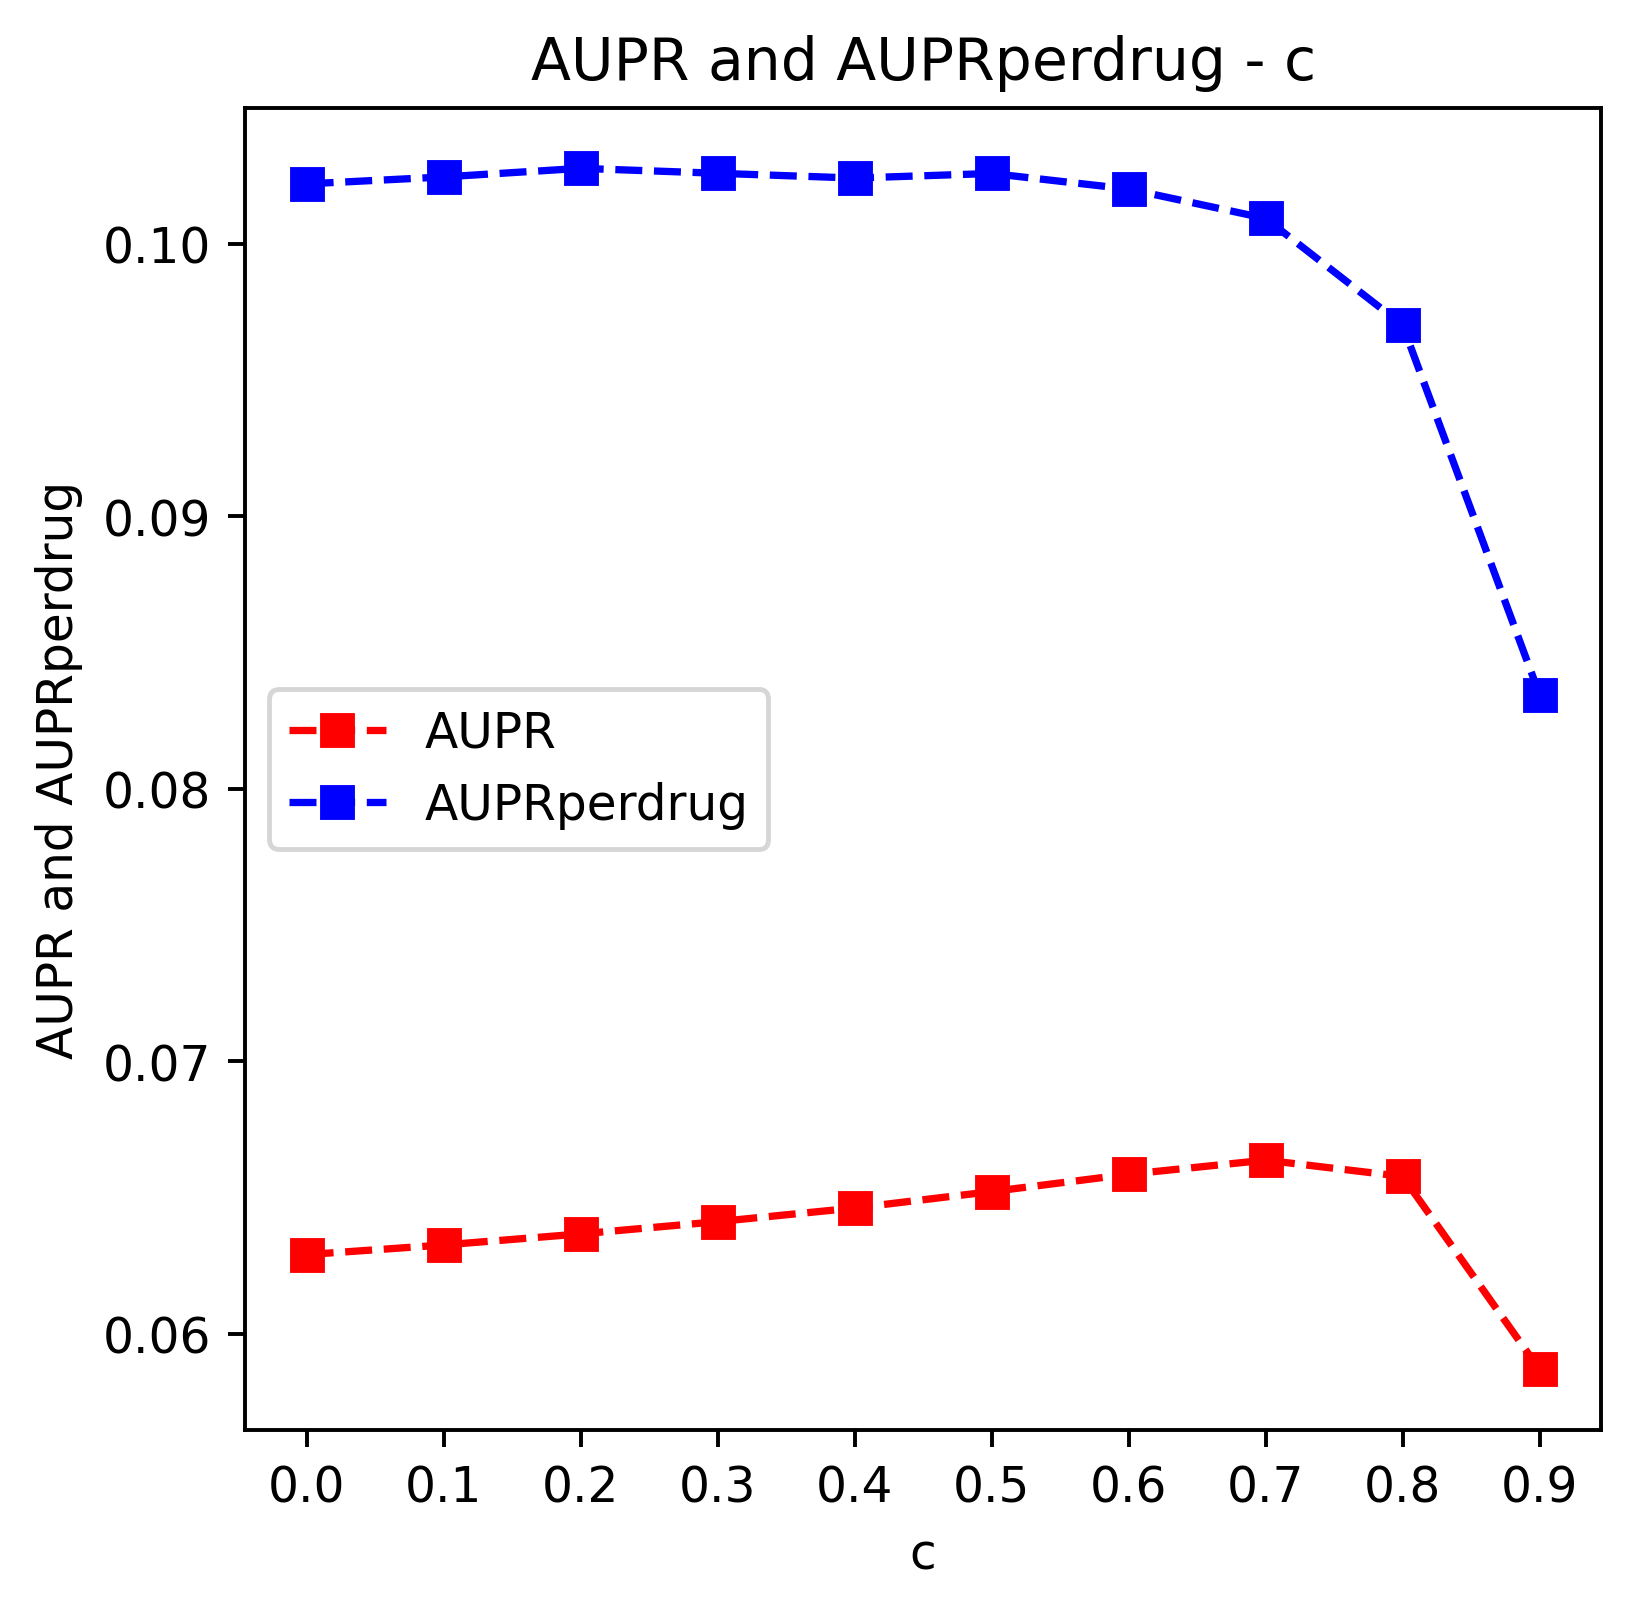

In [16]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUPR')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPRperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUPRperdrug')

# df = pd.DataFrame()
# for c, metrics in results.items():

#     df1 = pd.DataFrame(metrics["AUPR+AUROC"]).mean()
#     df = pd.concat([df, df1], ignore_index=True)

# plt.plot(df, marker='s', linestyle='--', color='black', label='Naive')

xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1))
# Add a legend
plt.legend()
plt.title("AUPR and AUPRperdrug - c")
plt.xlabel('c')
plt.ylabel('AUPR and AUPRperdrug')
plt.savefig(fname=f"figs/AUPR-C.jpg", bbox_inches="tight")
# Show the plot
plt.show()

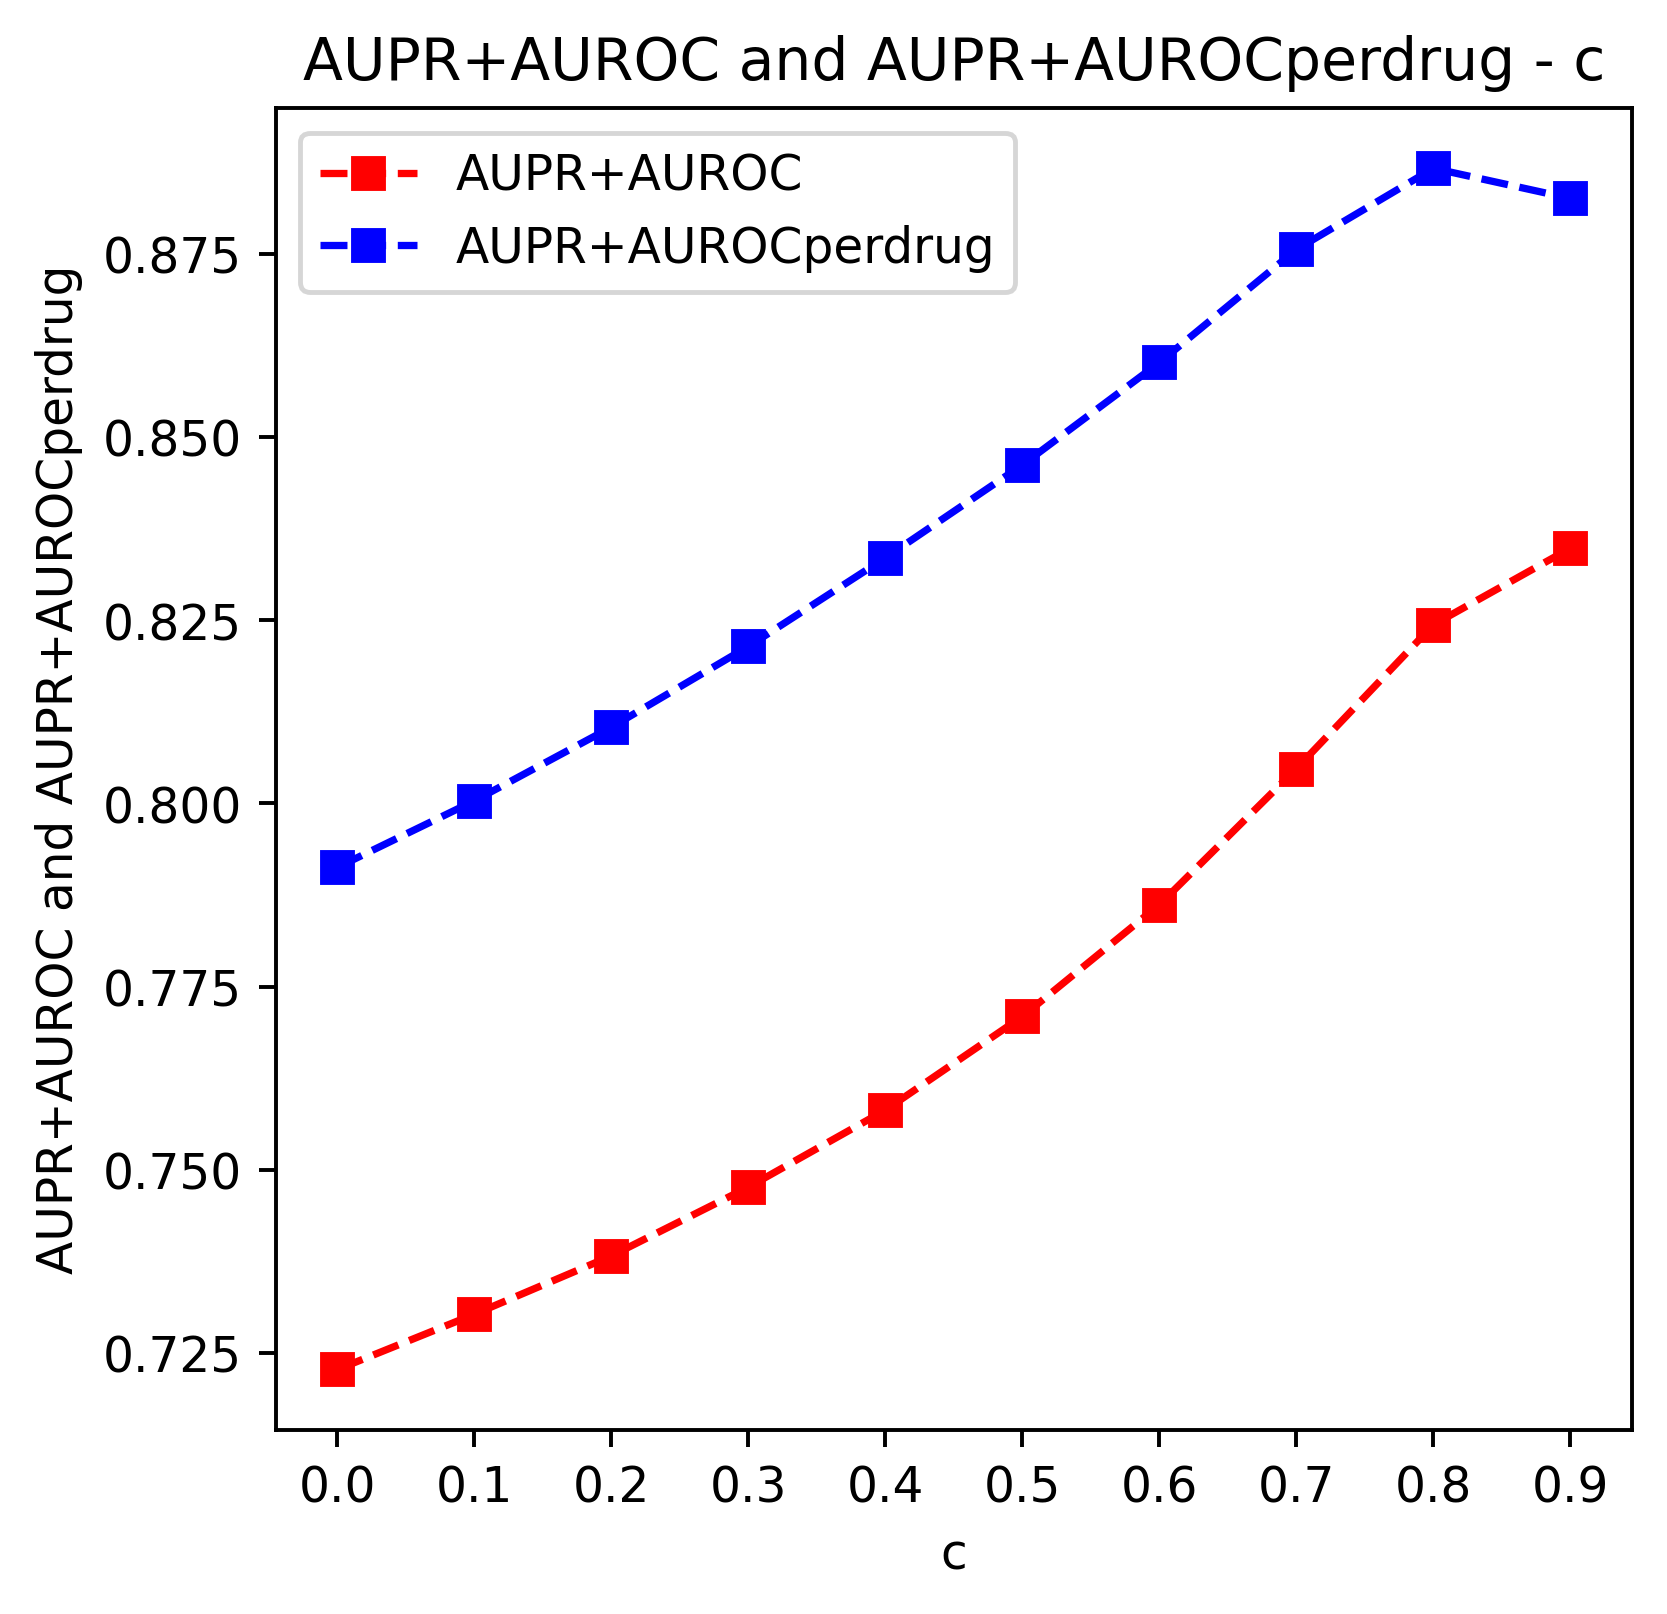

In [17]:
plt.figure(figsize=(5,5), dpi=350)
df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR+AUROC"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='r', label='AUPR+AUROC')

df = pd.DataFrame()
for c, metrics in results.items():

    df1 = pd.DataFrame(metrics["AUPR+AUROCperdrug"]).mean()
    df = pd.concat([df, df1], ignore_index=True)

plt.plot(df, marker='s', linestyle='--', color='b', label='AUPR+AUROCperdrug')

# df = pd.DataFrame()
# for c, metrics in results.items():

#     df1 = pd.DataFrame(metrics["AUPR+AUROC"]).mean()
#     df = pd.concat([df, df1], ignore_index=True)

# plt.plot(df, marker='s', linestyle='--', color='black', label='Naive')

xt = plt.xticks(np.arange(0, 10), np.arange(0, 1, 0.1).round(1))
# Add a legend
plt.legend()
plt.title("AUPR+AUROC and AUPR+AUROCperdrug - c")
plt.xlabel('c')
plt.ylabel('AUPR+AUROC and AUPR+AUROCperdrug')
plt.savefig(fname=f"figs/AUPR+AUROC-C.jpg", bbox_inches="tight")
# Show the plot
plt.show()

In [18]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score

In [19]:
y = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
p = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.8333333333333333

In [20]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
p = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.8

In [21]:
(0.83+0.8)/2

0.815

In [22]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
p = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.7988095238095239

In [ ]:
#1 

In [82]:
y = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
p = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.75

In [83]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
p = [1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.6833333333333333

In [84]:
(0.75+0.683)/2

0.7165

In [85]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
p = [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.65

In [86]:
y = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
p = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.05

In [87]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
p = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.8

In [88]:
(0.05+0.8)/2

0.42500000000000004

In [89]:
y = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
p = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
prec, recall, threshold = precision_recall_curve(y, p)
auc(recall, prec)

0.65